*Uploading the dataset cifar-10*




FUNCTION PROVIDED BY THE TRACK

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max() 
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)




Uploading train and test


In [ ]:
x_train_d,x_test_d=getDataset()

x_train=x_train_d[0]
y_train=x_train_d[1]
x_test=x_test_d[0]
y_test=x_test_d[1]

IMPORT OF LIBRARY

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, MaxPooling2D, Layer, Conv2D, concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras import utils
import numpy as np
import matplotlib.pyplot as plt

Model

The first layer in the model is the Input which require the shape of the input.

In [ ]:
input_shape=(32,32,3)
visible = Input(shape=input_shape)

The first 2 layers Conv2D of the model have the same number of filters. And they are Conv2D because these layers are that reducing the “noise” in the images using filtering the images.


In [ ]:
conv1_1=Conv2D(32,kernel_size=3,activation='relu', padding='same')(visible)
conv1_2=Conv2D(32,kernel_size=3,activation='relu', padding='same')(conv1_1)

The MaxPooling2D layer with pool_size 2 has the role to discretize the images "denoised" by the previous 2 layers. This layer also reduce the shape of the image from 32 to 16

In [ ]:
max_p_1=MaxPooling2D(pool_size=2)(conv1_2)


The next 2 layers have the role to reduce the "noise" 

In [ ]:
conv2_1=Conv2D(64,kernel_size=3,activation='relu', padding='same')(max_p_1)
conv2_2=Conv2D(64,kernel_size=3,activation='relu', padding='same')(conv2_1)

The layer max_p_2 has the role to reduce the shape of the image from 16 to 8 using the function of the MaxPooling2D 

In [ ]:
max_p_2=MaxPooling2D(pool_size=2)(conv2_2)


These 2 layers has the role to remove the noise in the images obtained by the layer max_p_2

In [ ]:
conv3_1=Conv2D(128,kernel_size=3,activation='relu', padding='same')(max_p_2)
conv3_2=Conv2D(128,kernel_size=3,activation='relu', padding='same')(conv3_1)

The next layer is a dropout layer, needed by the fact that the best way to reduce the mse during the fitting is doing a lot of epochs, but this process could be stopped by the overfitting. The best way to avoid it beyond using an EarlyStopping is also use a dropout layer.

In [ ]:
drop=Dropout(0.3)(conv3_2)


The images at this point of the model have the shape of 8, so we should reconstruct the real dimension of the image, and that is made by using the layer up_s_1

In [ ]:
up_s_1=UpSampling2D((2,2))(drop)


the input of the next layer is the concatenation of the simmetric layer for depth and the layer up_s_1 . The images at this point of the model has dimension of 16

In [ ]:
link1=concatenate([conv2_2,up_s_1])


In order to denoising the input of the link1 I choose to use 2 layers of Conv2D

In [ ]:
conv4_1=Conv2D(64,kernel_size=3,activation='relu', padding='same')(link1)
conv4_2=Conv2D(64,kernel_size=3,activation='relu', padding='same')(conv4_1)

Recunstruct the image from 16 to 32 using another UpSampling2D layer

In [ ]:
up_s_2=UpSampling2D((2,2))(conv4_2)


Concatenating the symmetry layer and the up_s_2 layer in order to estabilish a link between this simmetry process of reconstruction of images with that of discretization of the images.

In [ ]:
link2=concatenate([conv1_2,up_s_2])


Denoising the images reconstructed with simmetry layers

In [ ]:

conv5_1=Conv2D(32,kernel_size=3,activation='relu', padding='same')(link2)
conv5_2=Conv2D(32,kernel_size=3,activation='relu', padding='same')(conv5_1)

The output of the model should be the dimension of 32,32,3 so the last layer should have 3 filter

In [ ]:
conv6=Conv2D(3,kernel_size=1,activation='relu', padding='same')(conv5_2)


Building the model.

In [ ]:
model = Model(inputs=visible, outputs=conv6)

Model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

Plot of the model

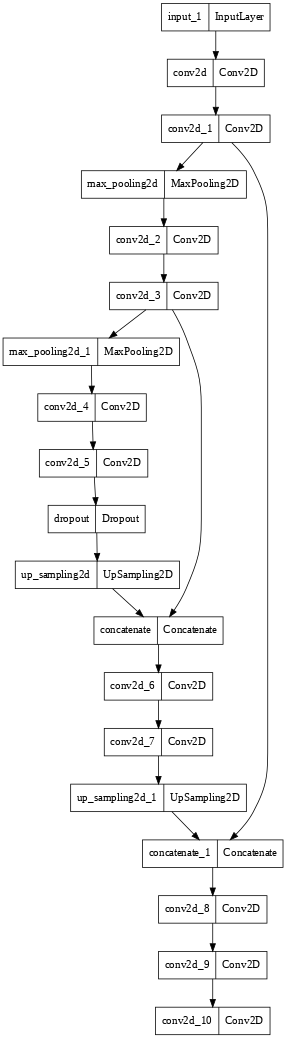

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png',dpi=55
           #show_shapes=True, show_layer_names=True
           )


Fitting of the model.
I choose to use an EarlyStopping to avoid overfitting monitoring the loss on the validation set ('mse') . 
The validation set is made by the train set

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping

history=model.fit(x_train, y_train ,epochs=200,validation_split=0.2,callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10))

Epoch 1/200
1250/1250 [==============================] - 28s 14ms/step - loss: 0.0060 - accuracy: 0.8003 - val_loss: 0.0033 - val_accuracy: 0.8408
Epoch 2/200
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0031 - accuracy: 0.8337 - val_loss: 0.0029 - val_accuracy: 0.8406
Epoch 3/200
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0029 - accuracy: 0.8361 - val_loss: 0.0028 - val_accuracy: 0.8320
Epoch 4/200
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0027 - accuracy: 0.8399 - val_loss: 0.0027 - val_accuracy: 0.8463
Epoch 5/200
1250/1250 [==============================] - 14s 11ms/step - loss: 0.0027 - accuracy: 0.8396 - val_loss: 0.0026 - val_accuracy: 0.8520
Epoch 6/200
1250/1250 [==============================] - 13s 11ms/step - loss: 0.0026 - accuracy: 0.8415 - val_loss: 0.0027 - val_accuracy: 0.8351
Epoch 7/200
1250/1250 [==============================] - 15s 12ms/step - loss: 0.0026 - accuracy: 0.8430 - val_loss: 0

As we can see there is no overfitting, looking at loss and accuracy of validation and test dataset.
The validation set has loss value of 0.0023 and the test set has loss value of 0.0023 compared to the loss of the train there is no overfitting or underfitting. 
The validation set has accuracy value of 0.86% and the test set has accuracy of 85% compared to the accuracy of the train there is no overfitting or underfitting. 

In [ ]:
res=model.evaluate(x_test,y_test)
print('mse: ',res[0],' acc: ',res[1])

313/313 [==============================] - 1s 5ms/step - loss: 0.0023 - accuracy: 0.8499
mse:  0.0023084799759089947  acc:  0.8498541116714478


Check of robustness 1

In [ ]:
def getDataset_modified(x_test,y_test):
                                                                 #modified here 0.09 instead of 0.02
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.09*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return  (createBlurred(x_test), y_test)



In [ ]:
test_d=getDataset_modified(x_test,y_test)

x_test_mod=test_d[0]
y_test_mod=test_d[1]



In [ ]:
res2=model.evaluate(x_test_mod,y_test_mod)
print('mse: ',res2[0],' acc: ',res2[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0154 - accuracy: 0.6813
mse:  0.015439621172845364  acc:  0.681311309337616


Check of robustness 2

In [ ]:

def getDataset_modified_2(x_test,y_test):
                                                        #mod.here (3,3) instead of (5,5)           #mod.here 0.5 instead of 0.02
  createBlurred = lambda arr: np.array([GaussianBlur(x, (3,3), ((random.random()*3)+1)) + (0.5*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return  (createBlurred(x_test), y_test)


In [ ]:
test_d=getDataset_modified_2(x_test,y_test)

x_test_mod_2=test_d[0]
y_test_mod_2=test_d[1]


In [ ]:
res3=model.evaluate(x_test_mod_2,y_test_mod_2)
print('mse: ',res3[0],' acc: ',res3[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.1125 - accuracy: 0.4549
mse:  0.11249703168869019  acc:  0.45487695932388306


Lack of overfitting

As we can see in the next 2 plots, the loss and the accuracy beetween train and validation set are closely similar.

Plot of loss during fitting

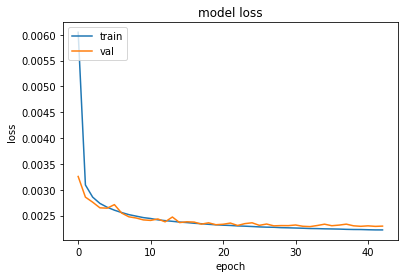

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Plot of accuracy during fitting 

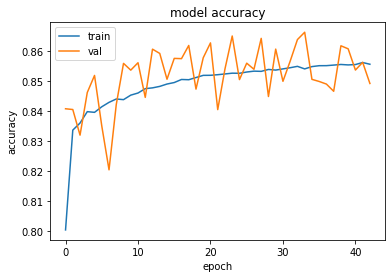

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Original and reconstructed images

In the first column is showed the blurred image, and in the second column is showed the reconstructed image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


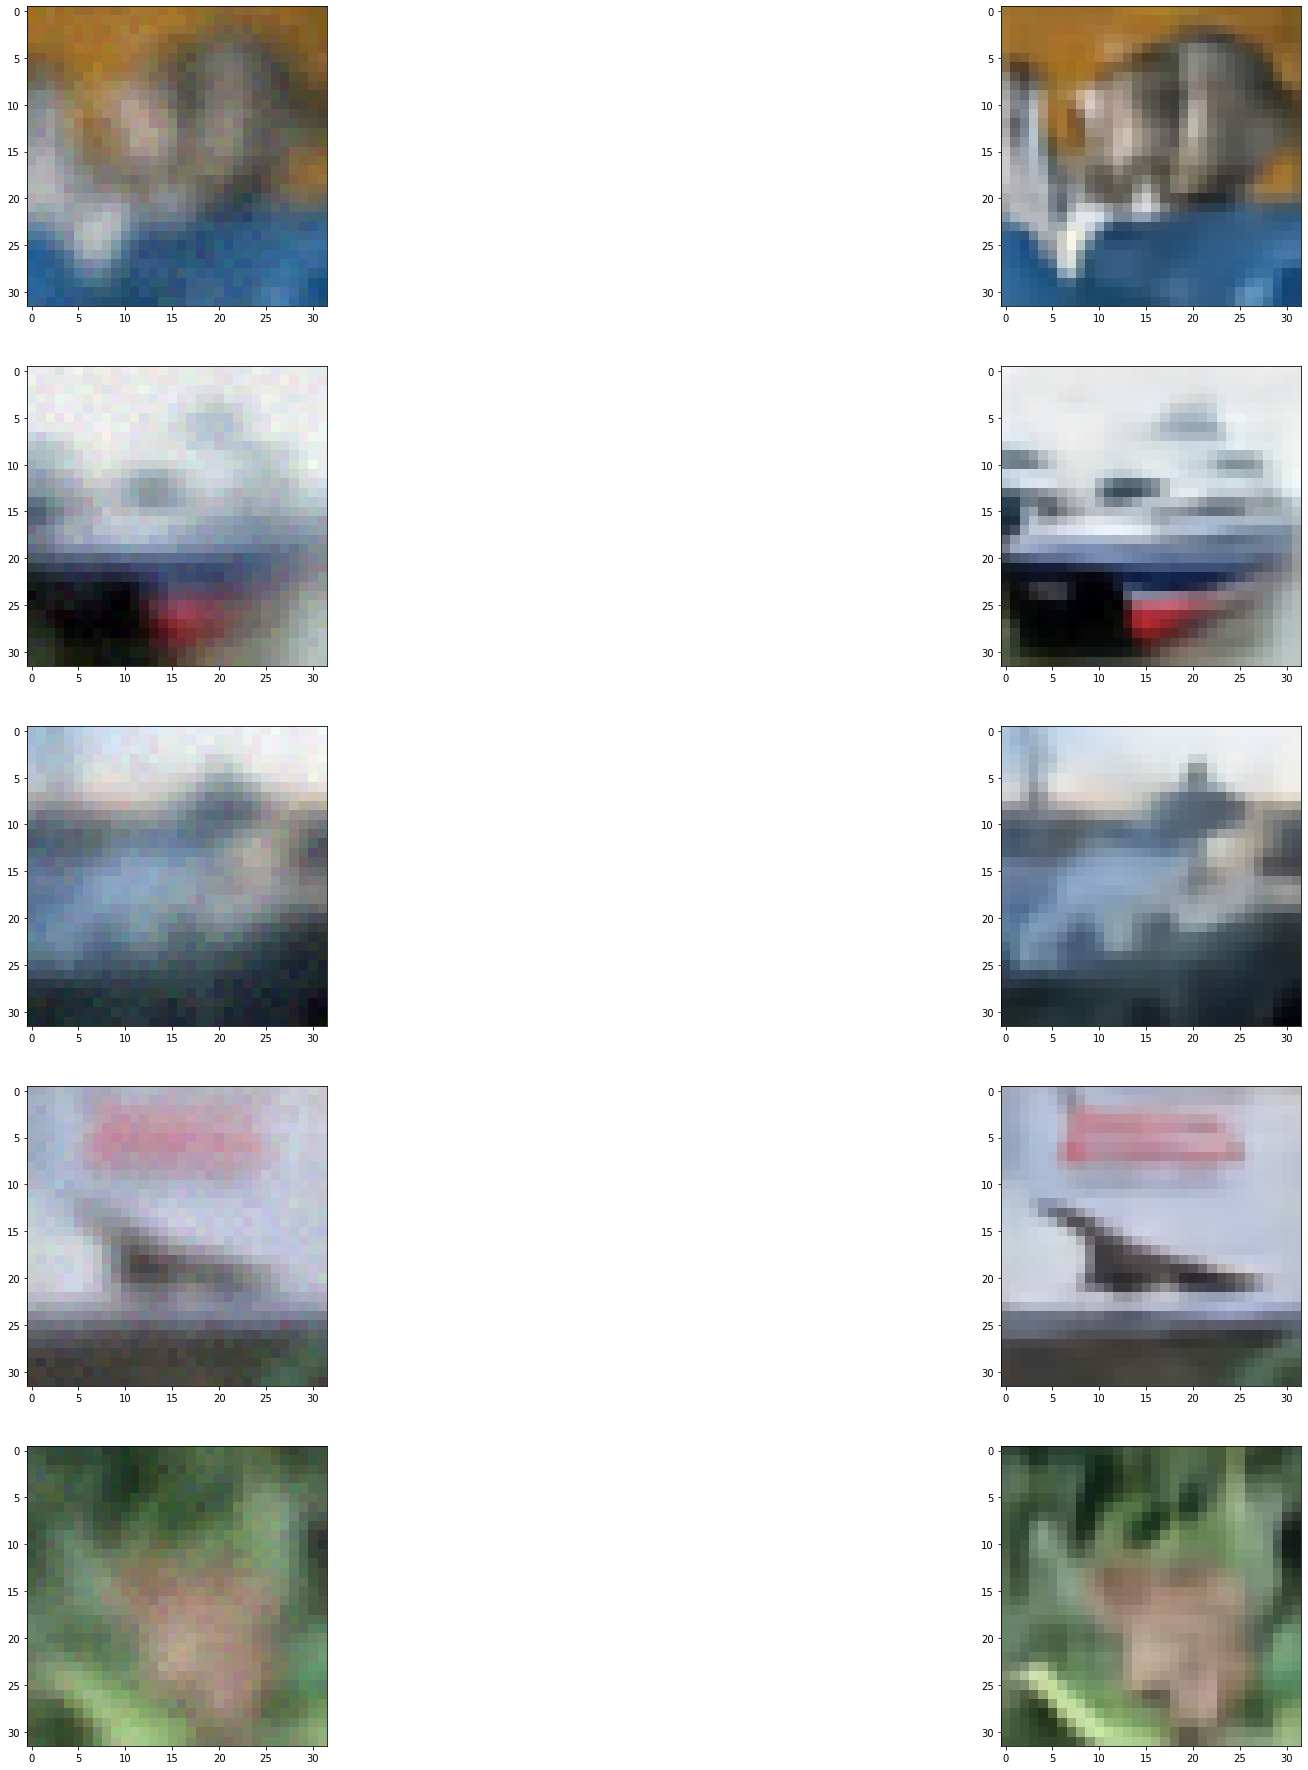

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pred=model.predict(x_test)
fig = plt.figure(figsize=(32,32))
columns = 2
rows = 5
j=0
for i in range(1, columns*rows +1,2):
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[j])

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(pred[j])
    j=j+1

plt.show()

Plot using interpolation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


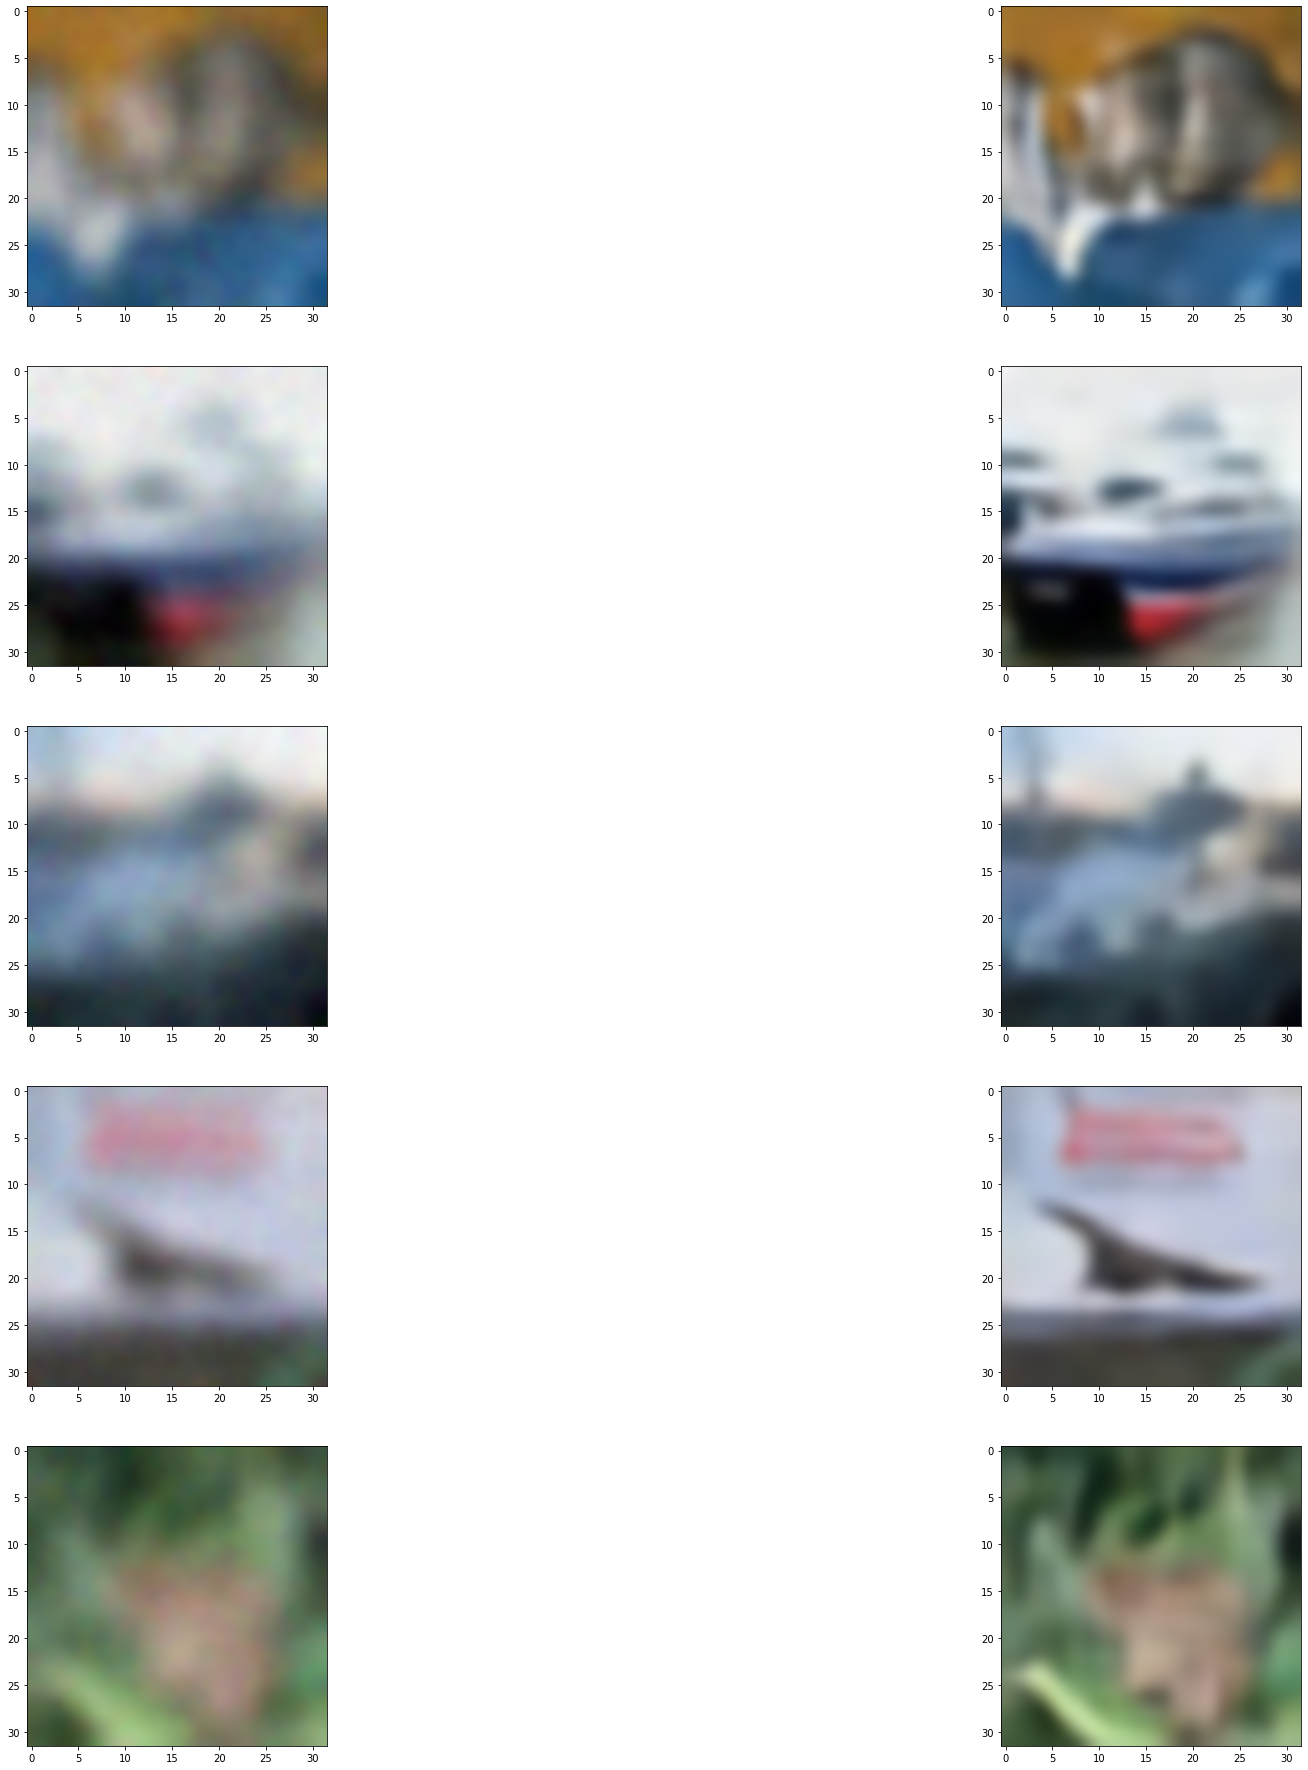

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pred=model.predict(x_test)
fig = plt.figure(figsize=(32,32))
columns = 2
rows = 5
j=0
for i in range(1, columns*rows +1,2):
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_test[j],interpolation='bicubic')

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(pred[j],interpolation='bicubic')
    j=j+1

plt.show()

Save weights and model

In [ ]:
!pip install pyyaml h5py 
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance


# Restore the weights
!mkdir -p saved_model
model.save('saved_model/my_model')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
!zip -r /content/file.zip /content/saved_model
from google.colab import files
files.download("/content/file.zip")
!zip -r /content/file.zip /content/checkpoints
from google.colab import files
files.download("/content/file.zip")



  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/my_model/ (stored 0%)
  adding: content/saved_model/my_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model/assets/ (stored 0%)
  adding: content/saved_model/my_model/variables/ (stored 0%)
  adding: content/saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/my_model/variables/variables.index (deflated 73%)
  adding: content/saved_model/my_model/keras_metadata.pb (deflated 94%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/checkpoints/ (stored 0%)
  adding: content/checkpoints/my_checkpoint.data-00000-of-00001 (deflated 8%)
  adding: content/checkpoints/my_checkpoint.index (deflated 73%)
  adding: content/checkpoints/checkpoint (deflated 49%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>